# Svm

In [1]:
import numpy as np
import sklearn.utils.extmath as sm
from numpy.linalg import inv
from numpy.linalg import eig
from numpy import dot, diag
from scipy.linalg import sqrtm
from scipy.spatial.distance import euclidean
import pandas as pd
import random, math
np.random.seed(42)
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Cluster kernel

In [2]:
def fill_diag(M, a):
    """
    M: square matrix
    a: array of length number of rows
    ----
    fill the diagonal of M with values of array a
    """
    s = M.shape
    D = np.zeros(s)
    for i in range(s[0]):
        D[i,i] = a[i]
    return D
# let A be a matrix, A.T is the transpose of A
def rbf_kernel(X, Y, sigma):
    K = np.zeros((len(X), len(X)))
    for a in range(len(X)):
        for b in range(len(X)):
            K[a, b] = rbf_function(X[a], X[b])
    return K
            
def rbf_function(x, y, sigma=1):
    exponent = - (euclidean(x, y)**2) / (2*(sigma**2))
    return np.exp(exponent)


def diagonal_row_sum_matrix(M):
    rows_sum = M.sum(axis=1)
    return fill_diag(M,rows_sum)

def computeL(D,K):
    Dinv = inv(D)
    return sqrtm(Dinv).dot(K).dot(sqrtm(Dinv))

def build_K(lambdaCut, transfer, X, Y=None, sigma=None):
    
    #Step 1 - K matrix
    K = rbf_kernel(X, Y, sigma)
    D = diagonal_row_sum_matrix(K)
    
    #Step 2 - L matrix
    L = computeL(D, K)
    eigen_vals, U = eig(L)
    Q = diag(eigen_vals)
    
    #Step 3 - Transfer Function
    #choosing lambdacut
    lambdaCut=1
    newEigen = transfer(eigen_vals, lambdaCut)
    newEigen = diag(newEigen)
    
    #Step 4 - New Kernel matrix
    newL = U.dot(newEigen).dot(U.T)
    newD = inv(diag(diag(L)))
    newK = sqrtm(newD).dot(newL).dot(sqrtm(newD))
    return newK
    

#TRANSFER FUNCTION
def linear(vals, lambdaCut):
    return vals

def step(vals,lambdaCut):
    return [ 1 if x >= lambdaCut else 0 for x in vals ]

def linear_step(vals, lambdaCut):
    return [ x if x >= lambdaCut else 0 for x in vals ]

def polynomial(vals, exponent):
    return [ np.power(x, exponent) for x in vals ]

In [3]:
#dummy example
nb_samples = 4 #nb of samples
dim_sample = 5
X = np.random.rand(nb_samples,dim_sample)
lambdaCut = 1
K = build_K(lambdaCut, linear, X)
print(K)

[[1.         0.55785116 0.86690506 0.76205176]
 [0.55785116 1.         0.52756031 0.82683934]
 [0.86690506 0.52756031 1.         0.73180201]
 [0.76205176 0.82683934 0.73180201 1.        ]]


In [4]:
#Defining a linear Kernel
def kernel_1(li1,li2):
    #assuming that li1 and li2 are numpy arrays
    scalar_product=np.sum(li1*li2)
    return scalar_product

#defining a polynomial kernel with degree p
def kernel_2(li1,li2,p):
    scalar_product=np.sum(li1*li2)
    value=math.pow((scalar_product+1),p)
    return value

#distance function for Gaussian Kernel
def dist(l1,l2):
    li3=l1-l2
    li3=li3*li3
    dist_sq=np.sum(li3)
    return dist_sq

#defining a gaussian kernel with parameter gamma
def kernel_3(li1,li2,gamma):
    Distance_sq=dist(li1,li2)
    temp=gamma*Distance_sq
    value=math.exp(-temp)
    return value

def choose_kernel(num,li1,li2,deg=0,gamma=0):
    if(num==1):
        return kernel_1(li1,li2)
    elif(num==2):
        return kernel_2(li1,li2,deg)
    elif(num==3):
        return kernel_3(li1,li2,gamma)
    else:
        K = build_K(step, X)
        return K[i][j]

In [18]:
def pre_cal(data_list,t_list,kernel,deg,gamma):
    
    P_matrix=[]
    
    for i in range(len(t_list)):
        tmp_li=[]
        for j in range(len(t_list)):
            tmp_li.append(t_list[i]*t_list[j]*choose_kernel(kernel,data_list[i],data_list[j],deg,gamma))
        tmp_li=np.array(tmp_li)
        P_matrix.append(tmp_li) #p matrix has been created

    return P_matrix

def zerofun(alpha_list):
    return np.dot(alpha_list,t_list) #this is the value which should be constrained to zero


def objective(alpha_list):
    
    sum1=0
    sum2=0    
    for i in range(len(alpha_list)):
        sum1+=alpha_list[i]
        sum2+=alpha_list[i]*np.dot(alpha_list,P_mat[i]) #here alpha list is assumed to be numpy array

    sum2=sum2/2

    return (sum2-sum1)

def indicator(new_data, data_list, t_list, kernel, alpha_list, b):
    sum=0
    #print(alpha_list)
    for i in range(len(alpha_list)):
        if(alpha_list[i]!=0):
            sum+=alpha_list[i]*t_list[i]*choose_kernel(kernel,new_data,data_list[i],deg,gamma)
        else:
            continue

    ind=(sum-b)

    return ind

def ret_b(data_list, t_list, kernel, support_vector, alpha_list, support_target):

    sum_value = 0
    for i in range(len(alpha_list)):
        if(alpha_list[i] != 0):
            sum_value += alpha_list[i]*t_list[i]*choose_kernel(kernel,support_vector,data_list[i],deg,gamma)
        else:
            continue

    return (sum_value - support_target)

In [19]:
def plot(ClassA,ClassB,filtered_alphas,b,kernel,slack):

    plt.plot([p[0] for p in ClassA],[p[1] for p in ClassA],'b.')
    plt.plot([p[0] for p in ClassB],[p[1] for p in ClassB],'r.')
    plt.axis('equal')

    xgrid=np.linspace(-5,5)  #by default it is 50 in numpy
    ygrid=np.linspace(-4,4)  


    grid=np.array([[indicator(np.array([x,y]), data_list, t_list, kernel, filtered_alphas,b) for x in xgrid]for y in ygrid])
    #print(grid)
    plt.contour(xgrid,ygrid,grid,(-1,0,1),colors=('red','black','blue'),linewidths=(1,3,1))
    plt.xlabel("Feature1")
    plt.ylabel("Feature2")
    plt.title("Decision Boundary with Margins with C value : "+str(slack))
    #plt.savefig("part4_rbf_1_C_"+str(slack)+".png")
    plt.show()

In [20]:
def train(data_list, t_list, kernel, slack):
    ret = minimize(objective,np.zeros(N),bounds=[(0,slack) for b in range(data_list.shape[0])],constraints={'type':'eq','fun':zerofun})
    alphas = ret['x']
    filtered_alphas = []
    for i in range(len(alphas)):
        #if the alpha is less 10-5 then i will consider it as 0 === TRESHOLD
        if(alphas[i]<math.pow(10,-5)):
            filtered_alphas.append(0)
        else:
            support_vec=data_list[i]
            support_target=t_list[i]
            filtered_alphas.append(alphas[i])
    b = ret_b(data_list, t_list, kernel, support_vec, filtered_alphas, support_target)
    
    return filtered_alphas, b

# JADE THIS IS ITTTTTT

[1. 3.]  ,  [1. 3.]
[1. 3.]  ,  [2. 3.]
[1. 3.]  ,  [1. 2.]
[1. 3.]  ,  [1.5 1. ]
[1. 3.]  ,  [3.  1.5]
[1. 3.]  ,  [2.  1.5]
[1. 3.]  ,  [7. 9.]
[1. 3.]  ,  [8. 7.]
[1. 3.]  ,  [8. 9.]
[1. 3.]  ,  [7.5 8. ]
[1. 3.]  ,  [9.  7.5]
[2. 3.]  ,  [1. 3.]
[2. 3.]  ,  [2. 3.]
[2. 3.]  ,  [1. 2.]
[2. 3.]  ,  [1.5 1. ]
[2. 3.]  ,  [3.  1.5]
[2. 3.]  ,  [2.  1.5]
[2. 3.]  ,  [7. 9.]
[2. 3.]  ,  [8. 7.]
[2. 3.]  ,  [8. 9.]
[2. 3.]  ,  [7.5 8. ]
[2. 3.]  ,  [9.  7.5]
[1. 2.]  ,  [1. 3.]
[1. 2.]  ,  [2. 3.]
[1. 2.]  ,  [1. 2.]
[1. 2.]  ,  [1.5 1. ]
[1. 2.]  ,  [3.  1.5]
[1. 2.]  ,  [2.  1.5]
[1. 2.]  ,  [7. 9.]
[1. 2.]  ,  [8. 7.]
[1. 2.]  ,  [8. 9.]
[1. 2.]  ,  [7.5 8. ]
[1. 2.]  ,  [9.  7.5]
[1.5 1. ]  ,  [1. 3.]
[1.5 1. ]  ,  [2. 3.]
[1.5 1. ]  ,  [1. 2.]
[1.5 1. ]  ,  [1.5 1. ]
[1.5 1. ]  ,  [3.  1.5]
[1.5 1. ]  ,  [2.  1.5]
[1.5 1. ]  ,  [7. 9.]
[1.5 1. ]  ,  [8. 7.]
[1.5 1. ]  ,  [8. 9.]
[1.5 1. ]  ,  [7.5 8. ]
[1.5 1. ]  ,  [9.  7.5]
[3.  1.5]  ,  [1. 3.]
[3.  1.5]  ,  [2. 3.]
[3.  1.5]  ,  

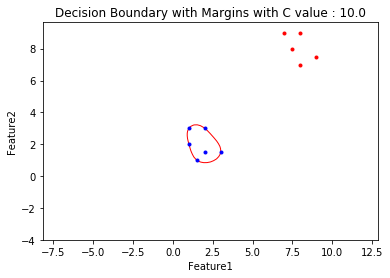

[1. 3.]  ,  [1. 3.]
[1. 3.]  ,  [2. 3.]
[1. 3.]  ,  [1. 2.]
[1. 3.]  ,  [1.5 1. ]
[1. 3.]  ,  [3.  1.5]
[1. 3.]  ,  [2.  1.5]
[1. 3.]  ,  [7. 9.]
[1. 3.]  ,  [8. 7.]
[1. 3.]  ,  [8. 9.]
[1. 3.]  ,  [7.5 8. ]
[1. 3.]  ,  [9.  7.5]
[2. 3.]  ,  [1. 3.]
[2. 3.]  ,  [2. 3.]
[2. 3.]  ,  [1. 2.]
[2. 3.]  ,  [1.5 1. ]
[2. 3.]  ,  [3.  1.5]
[2. 3.]  ,  [2.  1.5]
[2. 3.]  ,  [7. 9.]
[2. 3.]  ,  [8. 7.]
[2. 3.]  ,  [8. 9.]
[2. 3.]  ,  [7.5 8. ]
[2. 3.]  ,  [9.  7.5]
[1. 2.]  ,  [1. 3.]
[1. 2.]  ,  [2. 3.]
[1. 2.]  ,  [1. 2.]
[1. 2.]  ,  [1.5 1. ]
[1. 2.]  ,  [3.  1.5]
[1. 2.]  ,  [2.  1.5]
[1. 2.]  ,  [7. 9.]
[1. 2.]  ,  [8. 7.]
[1. 2.]  ,  [8. 9.]
[1. 2.]  ,  [7.5 8. ]
[1. 2.]  ,  [9.  7.5]
[1.5 1. ]  ,  [1. 3.]
[1.5 1. ]  ,  [2. 3.]
[1.5 1. ]  ,  [1. 2.]
[1.5 1. ]  ,  [1.5 1. ]
[1.5 1. ]  ,  [3.  1.5]
[1.5 1. ]  ,  [2.  1.5]
[1.5 1. ]  ,  [7. 9.]
[1.5 1. ]  ,  [8. 7.]
[1.5 1. ]  ,  [8. 9.]
[1.5 1. ]  ,  [7.5 8. ]
[1.5 1. ]  ,  [9.  7.5]
[3.  1.5]  ,  [1. 3.]
[3.  1.5]  ,  [2. 3.]
[3.  1.5]  ,  

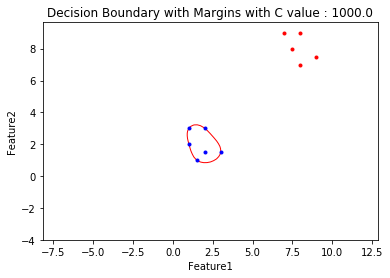

In [24]:
#data: inputs and targets are global variables used in other functions
data_list = np.array([[1. ,3.], [2., 3.], [1., 2.], [1.5, 1.], [3., 1.5], [2., 1.5], [7., 9.], [8., 7.], [8., 9.], [7.5, 8.], [9., 7.5]])
t_list = np.array([-1., -1.,-1., -1., -1., -1., 1., 1., 1., 1., 1.])
N = data_list.shape[0]
cA = data_list[0:6]
cB = data_list[6:]

kernel = 3
deg = 3
gamma = 0.5

x=np.linspace(10,1000,2)
for slack in x:

    P_mat = pre_cal(data_list, t_list, kernel, deg, gamma)  #p matrix is initialised here
    filtered_alphas, b = train(data_list, t_list, kernel, slack)
    plot(cA, cB, filtered_alphas, b, kernel, slack)

# Digit dataset

In [47]:
import pickle
from numpy.core import multiarray
import pandas as pd

In [48]:
with open("../Dataset/digitDataset.pickle", "rb") as fp:
    digits = pickle.load(fp,encoding='bytes')

In [49]:
X = []
labels = []
for i in range(0, len(digits)):
    X.append(digits[i][0])
    labels.append(digits[i][1])
X = np.array(X)
labels = np.array(labels)

In [50]:
lambdaCut = 1
K = build_K(lambdaCut, step, X)

KeyboardInterrupt: 

#  This part is the random generated data - for people with trust issues

In [9]:
def create_clusters(lbA1, ubA1, lbA2, ubA2, lbB, ubB, spreadA, spreadB):
    classA = np.concatenate((np.random.randn(10,2) * spreadA + [lbA1, ubA1],
                           np.random.randn(10, 2) * spreadA + [lbA2, ubA2]))
    classB = np.random.randn(20, 2) * spreadB + [lbB, ubB]
    inputs = np.concatenate((classA, classB))
    targets = np.concatenate(
                (np.ones(classA.shape[0]),
                -np.ones(classB.shape[0])))

    N = inputs.shape[0]

    permute = list(range(N))
    random.shuffle(permute)
    inputs = inputs[permute, :]
    targets = targets[permute]
    return inputs, targets, N, classA, classB

In [10]:
def generate_data():

    #generating data
    classA=np.concatenate((np.random.randn(10,2)*0.5+[1.5,0.5],np.random.randn(10,2)*0.5+[-1.5,0.5]))
    classB=np.random.randn(10,2)*0.5+[0.0,-0.5]

    inputs=np.concatenate((classA,classB))
    targets=np.concatenate((np.ones(classA.shape[0]),-np.ones(classB.shape[0])))

    N=inputs.shape[0]  #number of rows(samples)

    permute=list(range(N))
    random.shuffle(permute)

    #data_list and t_list are global variables
    inputs=inputs[permute,:]  
    targets=targets[permute]

    return (classA,classB,inputs,targets)

[-1.59264383  0.43508965]  ,  [-1.59264383  0.43508965]
[-1.59264383  0.43508965]  ,  [0.28449154 0.31419831]
[-1.59264383  0.43508965]  ,  [ 0.83885041 -0.77679412]
[-1.59264383  0.43508965]  ,  [-1.54414102  1.78985467]
[-1.59264383  0.43508965]  ,  [-0.32463877 -1.11197013]
[-1.59264383  0.43508965]  ,  [-0.18956387 -0.60179018]
[-1.59264383  0.43508965]  ,  [-1.18311156  0.70689955]
[-1.59264383  0.43508965]  ,  [ 0.11689296 -1.27794782]
[-1.59264383  0.43508965]  ,  [1.52443004 0.52029585]
[-1.59264383  0.43508965]  ,  [0.87806838 0.1535474 ]
[-1.59264383  0.43508965]  ,  [ 0.6138345  -1.10482051]
[-1.59264383  0.43508965]  ,  [ 0.16544012 -0.08323552]
[-1.59264383  0.43508965]  ,  [0.79869736 1.37478837]
[-1.59264383  0.43508965]  ,  [-1.01806044  1.6052615 ]
[-1.59264383  0.43508965]  ,  [-2.09379921  0.65491036]
[-1.59264383  0.43508965]  ,  [-1.77874589 -0.18490149]
[-1.59264383  0.43508965]  ,  [1.56114875 0.77164901]
[-1.59264383  0.43508965]  ,  [-0.29084046 -1.00737837]
[-

[0.79869736 1.37478837]  ,  [-1.59264383  0.43508965]
[0.79869736 1.37478837]  ,  [0.28449154 0.31419831]
[0.79869736 1.37478837]  ,  [ 0.83885041 -0.77679412]
[0.79869736 1.37478837]  ,  [-1.54414102  1.78985467]
[0.79869736 1.37478837]  ,  [-0.32463877 -1.11197013]
[0.79869736 1.37478837]  ,  [-0.18956387 -0.60179018]
[0.79869736 1.37478837]  ,  [-1.18311156  0.70689955]
[0.79869736 1.37478837]  ,  [ 0.11689296 -1.27794782]
[0.79869736 1.37478837]  ,  [1.52443004 0.52029585]
[0.79869736 1.37478837]  ,  [0.87806838 0.1535474 ]
[0.79869736 1.37478837]  ,  [ 0.6138345  -1.10482051]
[0.79869736 1.37478837]  ,  [ 0.16544012 -0.08323552]
[0.79869736 1.37478837]  ,  [0.79869736 1.37478837]
[0.79869736 1.37478837]  ,  [-1.01806044  1.6052615 ]
[0.79869736 1.37478837]  ,  [-2.09379921  0.65491036]
[0.79869736 1.37478837]  ,  [-1.77874589 -0.18490149]
[0.79869736 1.37478837]  ,  [1.56114875 0.77164901]
[0.79869736 1.37478837]  ,  [-0.29084046 -1.00737837]
[0.79869736 1.37478837]  ,  [-1.836745

[1.14900416 0.16854954]  ,  [-1.54414102  1.78985467]
[1.14900416 0.16854954]  ,  [-0.32463877 -1.11197013]
[1.14900416 0.16854954]  ,  [-0.18956387 -0.60179018]
[1.14900416 0.16854954]  ,  [-1.18311156  0.70689955]
[1.14900416 0.16854954]  ,  [ 0.11689296 -1.27794782]
[1.14900416 0.16854954]  ,  [1.52443004 0.52029585]
[1.14900416 0.16854954]  ,  [0.87806838 0.1535474 ]
[1.14900416 0.16854954]  ,  [ 0.6138345  -1.10482051]
[1.14900416 0.16854954]  ,  [ 0.16544012 -0.08323552]
[1.14900416 0.16854954]  ,  [0.79869736 1.37478837]
[1.14900416 0.16854954]  ,  [-1.01806044  1.6052615 ]
[1.14900416 0.16854954]  ,  [-2.09379921  0.65491036]
[1.14900416 0.16854954]  ,  [-1.77874589 -0.18490149]
[1.14900416 0.16854954]  ,  [1.56114875 0.77164901]
[1.14900416 0.16854954]  ,  [-0.29084046 -1.00737837]
[1.14900416 0.16854954]  ,  [-1.83674531  0.63949708]
[1.14900416 0.16854954]  ,  [1.35252516 1.12387104]
[1.14900416 0.16854954]  ,  [1.56261225 0.28529723]
[1.14900416 0.16854954]  ,  [ 0.01704173

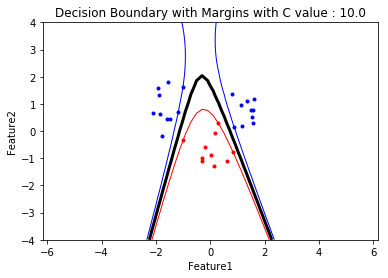

In [23]:
kernel = 2
deg = 2
gamma = 0.5

cA,cB,data_list,t_list=generate_data()  #this generates the data
N = data_list.shape[0]
x=np.linspace(10,1000,1)
for slack in x:
    
    P_mat = pre_cal(data_list, t_list, kernel, deg, gamma)  #p matrix is initialised here
    print(data_list)
    filtered_alphas, b = train(data_list, t_list, kernel, slack)
    plot(cA, cB, filtered_alphas, b, kernel, slack)

In [ ]:
#Jade generated data
data_list, t_list, N, cA, cB = create_clusters(random.uniform(-5,5), random.uniform(-5,5), random.uniform(-5,5), 
                                                         random.uniform(-5,5), random.uniform(-5,5), random.uniform(-5,5), random.uniform(0,1), random.uniform(0,1))
x=np.linspace(10,1000,1)
for slack in x:

    P_mat = pre_cal(data_list, t_list, kernel, deg, gamma)  #p matrix is initialised here
    filtered_alphas, b = train(data_list, t_list, kernel, slack)
    plot(cA, cB, filtered_alphas, b, kernel, slack)